In [1]:
###the folllowing libraries will be neeeded
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import warnings
warnings.filterwarnings('ignore')

# Fault reactivation $\frac{\tau}{\sigma_d}$

###  The equations and notes used in the code were based from the lecture [notes](https://dnicolasespinoza.github.io/IPG.html) by professor Nicholas Espinoza

#### The begineing explains all the code. An example procedure begines in In [11] if you want to skip to it.

##### this is a work in progress feedback is welcomed, if any errors are found please email me at danielbarrera@utexas.edu

The 3D mohr circle can be used to obtain the solutions of normal stresses and shear stresses on a given plane. Altough geometrically simple it is only preffered when the plane in question happens to be colinear with a principal stress. If the plane happens to intersect the element at an oblique angle to the principal stresses, linear algebra is necessesary to obtain  $\frac{\tau}{\sigma_d}$. 

The following functions outlines the procedure in plotting the mohr circle.

### Type of fault
Firstly lets define a class with the properties of the fault. A fault will be described by inputing the vertical, horizontal stresses and current pore pressure. It is importat to determine which kind of fault regime we are deeling with. A simple if function takes care of this inside the fault.

In [2]:
class fault:
    def __init__(self, Sv, S_hmax, S_hmin,Pp,mu,azimuth_shmin):
        self.Sv=Sv
        self.S_hmax=S_hmax
        self.S_hmin=S_hmin
        self.Pp=Pp
        self.mu=mu
        self.azimuth_shmin=azimuth_shmin
        self.azimuth_shmax=azimuth_shmin+90
        
def TypeFaulting(fault):
        if fault.Sv>fault.S_hmax and fault.Sv>fault.S_hmin:
            fault_regime=['normal']
            S1=fault.Sv
            S2=fault.S_hmax
            S3=fault.S_hmin
        elif fault.S_hmax>fault.Sv and fault.S_hmin>fault.Sv:
            fault_regime=['reverse']
            S1=fault.S_hmax
            S2=fault.S_hmin
            S3=fault.Sv
        elif fault.S_hmax>fault.Sv and fault.Sv>fault.S_hmin:
            fault_regime=['strike']
            S1=fault.S_hmax
            S2=fault.Sv
            S3=fault.S_hmin
        fault.S1=S1
        fault.S2=S2
        fault.S3=S3
        fault.fault_regime=fault_regime
        return

### Mohr Circles

Once the S1, S2, S3 the mohr circle can be plotted, simple geometry is used. The center and radious of each circle is obtained, then a simple array with all anlges ranging from 0 to 180 degrees is created and the perimeter of each circle is plotted. The criterion line is used to determine which faults are at risk of slipping. This line can be plotted by using the coeficient of friction, since at large scale the earth is already broken, no cohesive strenght is present and thus the line can be simply expressed by $\tau=\mu*\sigma_d$

Once the oultines of the mohr circle can be found the ratio $\frac{\tau}{\sigma_d}$ can be displayed as a gradient with the redder colors having a higher values than the blue ones. To do this a simple mesh grid is applied.

In [3]:
def MohrCircle(fault):
    S1=fault.S1;S2=fault.S2;S3=fault.S3;Pp=fault.Pp;mu=fault.mu
        
    c1=((S1-Pp)+(S3-Pp))/2; r1=((S1-Pp)-(S3-Pp))/2
    c2=((S1-Pp)+(S2-Pp))/2; r2=((S1-Pp)-(S2-Pp))/2
    c3=((S2-Pp)+(S3-Pp))/2; r3=((S2-Pp)-(S3-Pp))/2
    
    angles=np.linspace(0, np.pi, num=100)
    circle_1x=r1*np.cos(angles)+c1; circle_1y=r1*np.sin(angles)
    circle_2x=r2*np.cos(angles)+c2; circle_2y=r2*np.sin(angles)
    circle_3x=r3*np.cos(angles)+c3; circle_3y=r3*np.sin(angles)
    sig_n=np.linspace(0, 1.1*(S1-Pp), num=100); tau=mu*sig_n

        #this will put the t/sigma n 
    R=np.linspace(0,r1, num=100); Theta,Rad_g=np.meshgrid(angles,R)
    Y1=Rad_g*np.sin(Theta); X1=Rad_g*np.cos(Theta)+c1 ;Z1=np.divide(Y1, X1)
    
    R=np.linspace(0,r2,num=100); Theta,Rad_g=np.meshgrid(angles,R)
    Y2=Rad_g*np.sin(Theta); X2=Rad_g*np.cos(Theta)+c2; Z2=np.divide(Y2, X2)-np.divide(Y2, X2)
    
    R=np.linspace(0,r3,num=100); Theta,Rad_g=np.meshgrid(angles,R); Y3=Rad_g*np.sin(Theta)
    X3=Rad_g*np.cos(Theta)+c3; Z3=np.divide(Y3, X3)-np.divide(Y3, X3)
    #plttoing
    fig, ax = plt.subplots()    
    ax.pcolor(X1,Y1,Z1, cmap='jet'); ax.pcolor(X2,Y2,Z2, cmap='binary')
    ax.pcolor(X3,Y3,Z3, cmap='binary'); ax.plot(circle_1x,circle_1y,'b',
             circle_2x,circle_2y,'r',circle_3x,circle_3y,'k', sig_n,tau,'g');
    ax.set_xlim([0, 1.1*(S1-Pp)]); ax.set_ylim([0,0.5*(S1-Pp)])
    fault.figMohr=fig
    fault.axMohr=ax
    return  fault.figMohr,fault.axMohr

### Tensor Method
Now that there is a graphical representation of $\frac{\tau}{\sigma_d}$ what if we want to plot an oblique fault and see were it falls?. The following code uses the Tensor Method to solve for $\sigma_d$ and $\tau$ (*for simplicity it is assumed $S_v$ is a principal stress*)

First the orientation of principal stresses with respect to the geographical coordinate system. These angles are related to the azimuth of $S_{hmin}$ $S_{hmax}$ and the respective fault regime. A simple if function takes care of this.
The azimuths are given in azimuth notation ranging from 0 to 180 degrees

In [4]:
def angle_transform(fault):
    fault_regime=fault.fault_regime;azimuth_shmax=fault.azimuth_shmax;
    azimuth_shmin=fault.azimuth_shmin
    if fault_regime==['normal']:
        a=azimuth_shmin/180*np.pi; #convert to radians
        b=np.pi/2;
        y=0;
    elif fault_regime==['strike']:
        a=azimuth_shmax/180*np.pi;
        b=0;
        y=np.pi/2;
    elif fault_regime==['reverse']:
        a=azimuth_shmax/180*np.pi ;   #convert to radians
        b=0;
        y=0;
    fault.a=a;fault.b=b;fault.y=y
    return fault.a,fault.b,fault.y

Once the angles have been determined the change of basis matrix $R_{pg}$, and stress tensor in geographic cordinates $S_G$, can be caulcated using the the principal stress Matrix and linear algebra. For more information plese refer to proffesor Espinoza [5.2.1](https://dnicolasespinoza.github.io/node37.html#SECTION00642000000000000000)


In [5]:
def Matrix_transforms(fault):
    S1=fault.S1; S2=fault.S2; S3=fault.S3; a=fault.a; b=fault.b; y=fault.y
    S_p=np.matrix([[S1,0,0],
                   [0,S2,0],
                   [0,0,S3]])
    
    Rpg=np.array([[np.cos(a)*np.cos(b), np.sin(a)*np.cos(b), -1*np.sin(b)],
               [np.cos(a)*np.sin(b)*np.sin(y)-np.sin(a)*np.cos(y), np.sin(a)*np.sin(b)*np.sin(y)+np.cos(a)*np.cos(y), np.cos(b)*np.sin(y)],
               [np.cos(a)*np.sin(b)*np.cos(y)+np.sin(a)*np.sin(y), np.sin(a)*np.sin(b)*np.cos(y)-np.cos(a)*np.sin(y), np.cos(b)*np.cos(y)]])
    #Rpg=np.matrix.round(Rpg,3)
    Sg=Rpg.transpose()*S_p*Rpg
    fault.Sg=np.matrix.round(Sg,3)
    fault.Rpg=Rpg
    fault.S_p=S_p
    return fault.S_p,fault.Rpg,fault.Sg

The reason behind the rounding of matrices is that the opertions used by numpy have round off errors due to the natrue of floating numbers an article explaining thi is linked for more information about [this](https://docs.python.org/2/tutorial/floatingpoint.html)

Now the  fault plane coordinate system has to be obtained using the following functions:

In [6]:
def new_cordinates(strike,dip):
    s=strike/180*np.pi
    d=dip/180*np.pi
    n_n=np.matrix([[-np.sin(s)*np.sin(d)],
                   [np.cos(s)*np.sin(d)],
                   [-np.cos(d)]
                   ])
    n_n=np.matrix.round(n_n,5)
        
    n_s=np.matrix([[np.cos(s)],
                   [np.sin(s)],
                   [0]
                   ])
    n_s=np.matrix.round(n_s,5)
        
    n_d=np.matrix([[-np.sin(s)*np.cos(d)],
                   [np.cos(s)*np.cos(d)],
                   [np.sin(d)]
                   ])
    n_d=np.matrix.round(n_d,5)
    return n_n, n_s, n_d

Finally $\sigma_d$ and $\tau$ cab be obtained. To give intuition behind this code rememebr the purpose of the function is to obtain the stress normal to the plane, thus the use of dot products should be rining in your head if you have taken any kind of statics or solids class before. For more information plese refer to proffesor Espinoza [5.2.2](https://dnicolasespinoza.github.io/node37.html#SECTION00642000000000000000)

In [7]:
def oblique_stress_strain(Sg,n_n,n_s,n_d):
    t=np.dot(Sg,n_n)
    t=np.matrix.round(t,3)
    Sn=np.dot(t.transpose(),n_n)
    Sn=np.matrix.round(Sn,3)
    T_d=np.dot(t.transpose(),n_d)
    T_s=np.dot(t.transpose(),n_s)
    T_abs=np.sqrt(T_d**2+T_s**2)
    return Sn, T_abs

## Stereonets

Stereonets can be really useful in projecting the 3D fault into  a 2D plane.
In the previous functions, one was able to project the stress and strain using the Mohr circle. Altought useful, the Mohr projection is limited by the fact that the user cannot pinpoint as easily the strike and dip of a point. Stereonets solve this problem. The following funcitons describe how to plot a stereonet, and then how to project $\frac{\tau}{\sigma_d} inside it. In a way we are developing the area inside the mohr circles and spreding it onto the surface area of the stereonet

### Outline of Stereonet
The following equation plots the stereonte. Altought there is already a great library and tools in python to plot the stereont, for the purpose of this problem I decided to dive into the actual math behind it. Big thanks to [Standford University](https://structuralgeology.stanford.edu/sites/default) which had lots of resources behind the equations used to plot this.

In [8]:
def ster_outline():
    r=1;
    TH=np.linspace(0,2*np.pi,3601);
    X=r*np.cos(TH)
    Y=r*np.sin(TH)
    plt.figure(0)
    plt.plot(X,Y)
    plt.axis("equal")
    for x in range(9):
        dip_angle=x*(10*np.pi/180)
        h=-r*np.tan(dip_angle); rp=r/(np.cos(dip_angle));
        X=-h+rp*np.cos(TH); Y=rp*np.sin(TH);
        distance=np.square(X)+np.square(Y)
        indices=mlab.find(r<distance)
        X[indices]=float('nan')                 
        plt.plot(X,Y,'k:',-X,Y,'k:')
    for x in range(9):                         #####not raeally understood the cone
        cone=x*(10*np.pi/180)                   ######but it made since
        k=r/np.cos(cone); rp=r*np.tan(cone);
        X=rp*np.cos(TH); Y=k+rp*np.sin(TH);
        distance=np.square(X)+np.square(Y)
        indices=mlab.find(r<distance)
        Y[indices]=float('nan')
        plt.plot(X,Y,'k:',X,-Y,'k:')      
    return

Once the stereont has been plotted the fun begines. The work flow should be to create meshgrid of an "area" with all possible strikes(0 to 360) and dips(0 to 90) (*no need to specify direction of dip lef or right of strike since it is rotatting all the way to 360 degrees*). After this you can calculate the X and Y cordinate corresponding to each strike and dip using. Then you need to calucate $\frac{\tau}{\sigma_d}$ for each cordinate, a simple double for loop takes care of this, call the previous defined function to calculate to each point and append it to a ratio matrix (z). After this is done you can simply use the plt.pcolor to apply the color gradient.

In [9]:
def color_ster(Sg,Pp):
    strikes=np.linspace(0,360,num=100)
    dips=np.linspace(0, 90, num=100)
    r=1
    ST,DP=np.meshgrid(strikes,dips,indexing='ij')
    als=ST*np.pi/180; ald=als+np.pi/2;
    phid=DP*np.pi/180; 
    aln=ald+np.pi;
    phin=np.pi/2-phid;
    x=r*np.tan(np.pi/4-phin/2)*np.sin(aln);
    y=r*np.tan(np.pi/4-phin/2)*np.cos(aln);
    z=x+y; ####just to make the right size

    for i in range(len(strikes)):
        for j in range(len(dips)):
            n_n, n_s, n_d=new_cordinates(ST[i,j],DP[i,j])
            Sn, T_abs=oblique_stress_strain(Sg,n_n,n_s,n_d)
            z[i,j]=(T_abs)/((Sn-Pp));
    
    plt.pcolor(x,y,z, cmap='jet')

To plot single points inside the colored stereonet the x and y cordinate can be obtained witht the following code (a subset of the previous code)

In [10]:
def point_ster(strike,dip):
    r=1
    als=strike*np.pi/180; ald=als+np.pi/2;
    phid=dip*np.pi/180; 
    aln=ald+np.pi;
    phin=np.pi/2-phid;
    x=r*np.tan(np.pi/4-phin/2)*np.sin(aln);
    y=r*np.tan(np.pi/4-phin/2)*np.cos(aln);
    plt.plot(x,y,'ko')
    return

# Example Rutine (Normal Faulting)

Finally the previous functions can be further summarized into a rutine to faciliatat the plotting of a fault givent the strike and dip. Lets 10 random faults in a fault regime with the following properties

### $S_{hmin}=20$;$S_{hmax}=30$;$Sv=45$;$Pp=10$; $\mu =0.6$
$S_{hmin}$ going NS

Text(0,0.5,'tau')

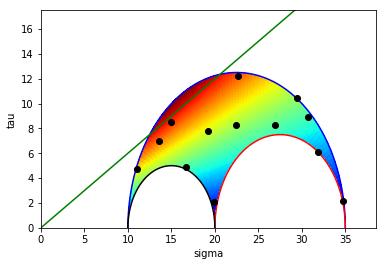

In [11]:
#random faults getting plotted as points
strikerand= 360*np.linspace(0.1,1,num=13); 
diprand= 90*np.random.rand(13);
#describing the fault
NormalFault=fault(45,30,20,10,0.6,0);
TypeFaulting(NormalFault) 
angle_transform(NormalFault);
Matrix_transforms(NormalFault);
MohrCircle(NormalFault)
for i in range (len(strikerand)):
    n_n, n_s, n_d=new_cordinates(strikerand[i],diprand[i])
    Sn, T_abs=oblique_stress_strain(NormalFault.Sg,n_n,n_s,n_d)
    plt.plot((Sn-NormalFault.Pp),T_abs,'ko')
plt.xlabel("sigma")
plt.ylabel("tau")

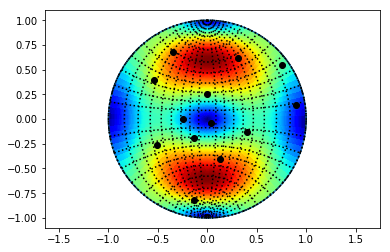

In [12]:
#creating the stereonent color
ster_outline()
color_ster(NormalFault.Sg,NormalFault.Pp)
point_ster(strikerand,diprand) 

# Example Rutine (Reverse Faulting)
### $S_{hmin}=30$;$S_{hmax}=40$;$Sv=20$;$Pp=10$; $\mu =0.6$

Text(0,0.5,'tau')

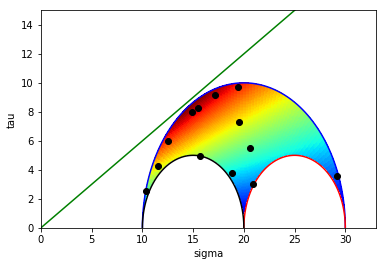

In [13]:
#random faults getting plotted as points
strikerand= 360*np.linspace(0.1,1,num=13); 
diprand= 90*np.random.rand(13);
#describing the fault
ReverseFault=fault(20,40,30,10,0.6,0);
TypeFaulting(ReverseFault) 
angle_transform(ReverseFault);
Matrix_transforms(ReverseFault);
MohrCircle(ReverseFault)
for i in range (len(strikerand)):
    n_n, n_s, n_d=new_cordinates(strikerand[i],diprand[i])
    Sn, T_abs=oblique_stress_strain(ReverseFault.Sg,n_n,n_s,n_d)
    plt.plot((Sn-ReverseFault.Pp),T_abs,'ko')
plt.xlabel("sigma")
plt.ylabel("tau")

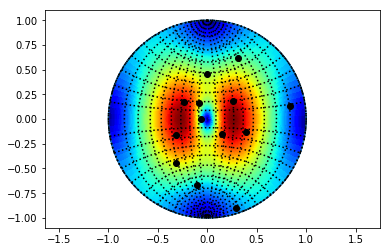

In [14]:
#creating the stereonent color
ster_outline()
color_ster(ReverseFault.Sg,ReverseFault.Pp)
point_ster(strikerand,diprand) 

# Example Rutine (Strike Slip Faulting)
### Shmin=25 ; Shmax=50 ; Sv=40 ; Pp=15 ;  μ=0.6

Text(0,0.5,'tau')

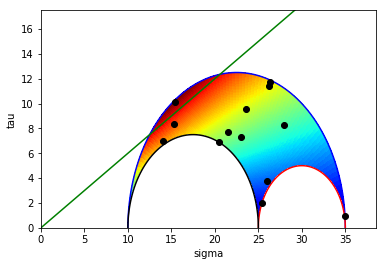

In [15]:
#random faults getting plotted as points
strikerand= 360*np.linspace(0.1,1,num=13); 
diprand= 90*np.random.rand(13);
#describing the fault
StrikeFault=fault(40,50,25,15,0.6,0);
TypeFaulting(StrikeFault) 
angle_transform(StrikeFault);
Matrix_transforms(StrikeFault);
MohrCircle(StrikeFault)
for i in range (len(strikerand)):
    n_n, n_s, n_d=new_cordinates(strikerand[i],diprand[i])
    Sn, T_abs=oblique_stress_strain(StrikeFault.Sg,n_n,n_s,n_d)
    plt.plot((Sn-StrikeFault.Pp),T_abs,'ko')
plt.xlabel("sigma")
plt.ylabel("tau")

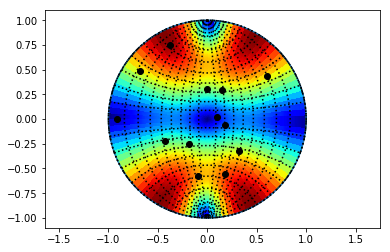

In [16]:
#creating the stereonent color
ster_outline()
color_ster(StrikeFault.Sg,StrikeFault.Pp)
point_ster(strikerand,diprand) 